### Training procedure notebook

This notebook is a step-by-step procedure in order to train a network (model) for axon & myelin segmentation in the AxonDeepSeg framework. It covers the following steps:

* How to train a model by scratch by defifing the parameters of the network.
* How to use the trained model to make predictions on new data.

Note: For the dataset patch management (i.e. how to prepare patches of samples & corresponding mask labels of the training dataset), please check the following notebook: name.ipynb.

### STEP 0: IMPORTS.

In [4]:
import json
import os
import time
from AxonDeepSeg.train_network import train_model

import tensorflow as tf
tf.reset_default_graph()

### STEP 1: TRAIN A NEW MODEL.

#### 1.1. Create subfolder to save new model and its parameters.

For simplicity, we create the new model folder under the 'models' folder of the AxonDeepSeg repository. The name of the model folder will be generated automatically using the date and time (to avoid multiple instances). If you want to use your own name, uncomment the 2nd line of the next cell.

In [5]:
dir_name = time.strftime("%Y-%m-%d") + '_' + time.strftime("%H-%M-%S")
# dir_name = 'the_name_of_my_model_folder'

path_model = os.path.join('../models/', dir_name)

if not os.path.exists(path_model):
    os.makedirs(path_model)

#### 1.2. Define the configuration parameters of the training.

Here, we are going to define the network and training parameters (i.e. hyperparameters). Here is a quick guide on the main parameters:

##### General parameters:
* **"n_classes":** Number of classes. For this application, the number of classes should be set to **3** (i.e. axon pixel, myelin pixel, or background pixel).
* **"thresholds":** Thresholds for the 3-class classification problem. Do not modify.
* **"trainingset_patchsize":** Patch size of the training set in pixels (note that the patches have the same size in both dimensions).
* **"trainingset":** Name of the training set.
* **"batch_size":** Batch size, i.e. the number of training patches used in one iteration of the training.

##### Network architecture parameters:
* **"depth":** Depth of the network (i.e. number of blocks of the U-net).
* **"convolution_per_layer":** Number of convolution layers used at each block.
* **"size_of_convolutions_per_layer":** Kernel size of each convolution layer of the network.
* **"features_per_convolution":** Number of features of each convolution layer.
* **"downsampling":** Type of downsampling to use in the downsampling layers of the network. Option "maxpooling" for standard max pooling layer or option "convolution" for learned convolutional downsampling.
* **"dropout":** Dropout to use for the training. Note: In TensorFlow, the keep probability is used instead. For instance, setting this param. to 0.75 means that 75% of the neurons of the network will be kept (i.e. dropout of 25%).


##### Training parameters:
* 


##### Data augmentation parameters:
* **"da-type":** Type of data augmentation procedure. Option **"all"** applies all selected data augmentation transformations sequentially, while option **"random"** only applies one of the selected transformations (randomly) to the sample(s).
* List of available data augmentation transformations: 'random_rotation', 'noise_addition', 'elastic', 'shifting', 'rescaling' and 'flipping'. For each type of data augmentation, the order needs to be specified if you decide to apply more than one transformation sequentially. For instance, setting the "da-0-shifting-activate" parameter to 'True' means that the shifting is the first transformation that will be applied to the sample(s) during training. 


##### Batch normalization parameters:
* 







In [ ]:
config = {
    
# General parameters:    
  "n_classes": 3,
  "thresholds": [0, 0.2, 0.8],    
  "trainingset_patchsize": 256,    
  "trainingset": "SEM_3c_256",    
  "batch_size": 8,

# Network architecture parameters:     
  "depth": 2,
  "convolution_per_layer": [2, 2],
  "size_of_convolutions_per_layer": [[3, 3], [3, 3]],
  "features_per_convolution": [[[1, 5], [5, 5]], [[5, 10], [10, 10]]],
  "downsampling": "maxpooling",
  "dropout": 0.75, 
     
# Learning rate parameters:    
  "learning_rate": 0.001,    
  "learning_rate_decay_activate": True,    
  "learning_rate_decay_period": 24000, 
  "learning_rate_decay_type": "polynomial", 
  "learning_rate_decay_rate": 0.99,
    
# Batch normalization parameters:     
  "batch_norm_activate": True,     
  "batch_norm_decay_decay_activate": True,    
  "batch_norm_decay_starting_decay": 0.7, 
  "batch_norm_decay_ending_decay": 0.9, 
  "batch_norm_decay_decay_period": 16000,
        

       
# Weighted cost parameters:    
  "weighted_cost-activate": True, 
  "weighted_cost-balanced_activate": True, 
  "weighted_cost-balanced_weights": [1.1, 1, 1.3], 
  "weighted_cost-boundaries_sigma": 2, 
  "weighted_cost-boundaries_activate": False, 
    
# Data augmentation parameters:    
  "da-type": "all", 
  "da-2-random_rotation-activate": False, 
  "da-5-noise_addition-activate": False, 
  "da-3-elastic-activate": True, 
  "da-0-shifting-activate": True, 
  "da-4-flipping-activate": True, 
  "da-1-rescaling-activate": False,
 
  "dataset_mean": 128,
  "dataset_variance": 30,
    
}

#### 1.3. Save config parameters of the network as configuration file (.json).

After the config parameters of the network to be trained are defined, we are going to save them as .json file in the model folder that we created previously. This .json file keeps tract of the network and model parameters in a structured way.

In [ ]:
if os.path.exists(path_model+filename):
    with open(path_model+filename, 'r') as fd:
        config_network = json.loads(fd.read())
else: # There is no config file for the moment
    with open(path_model+filename, 'w') as f:
        json.dump(config, f, indent=2)
    with open(path_model+filename, 'r') as fd:
        config_network = json.loads(fd.read())

In [2]:
filename = '/config_network.json'
trainingset_name = 'SEM_3c_256'
path_training = '/Users/rudinakaprata/Dropbox/SEM_3c_256/training'

Toy example:
* All convolutions kernels are 3x3
* Max pooling is used to downsample the feature maps
* 2 convoluation layers per depth (i.e. Conv-Conv-Downsample-Conv-Conv-Downsample-...)
* Number of feature channels: 5, then 10, then 15.


In [5]:
# Save config params of the network as configuration file (.json)

if os.path.exists(path_model+filename):
    with open(path_model+filename, 'r') as fd:
        config_network = json.loads(fd.read())
else: # There is no config file for the moment
    with open(path_model+filename, 'w') as f:
        json.dump(config, f, indent=2)
    with open(path_model+filename, 'r') as fd:
        config_network = json.loads(fd.read())

In [6]:
# Launch the training step
train_model(path_training, path_model, config)

('Layer: ', 0, ' Conv: ', 0, 'Features: ', [1, 5])
('Size:', 3)
('Layer: ', 0, ' Conv: ', 1, 'Features: ', [5, 5])
('Size:', 3)
('Layer: ', 1, ' Conv: ', 0, 'Features: ', [5, 10])
('Size:', 3)
('Layer: ', 1, ' Conv: ', 1, 'Features: ', [10, 10])
('Size:', 3)
('Layer: ', 2, ' Conv: ', 0, 'Features: ', [10, 15])
('Size:', 3)
('Layer: ', 2, ' Conv: ', 1, 'Features: ', [15, 15])
('Size:', 3)
('Layer: ', 0, ' Conv: ', 0, 'Features: ', [1, 5])
('Size:', 3)
('Layer: ', 0, ' Conv: ', 1, 'Features: ', [5, 5])
('Size:', 3)
('Layer: ', 1, ' Conv: ', 0, 'Features: ', [5, 10])
('Size:', 3)
('Layer: ', 1, ' Conv: ', 1, 'Features: ', [10, 10])
('Size:', 3)
('Layer: ', 2, ' Conv: ', 0, 'Features: ', [10, 15])
('Size:', 3)
('Layer: ', 2, ' Conv: ', 1, 'Features: ', [15, 15])
('Size:', 3)
Total number of parameters to train: 16463
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_w

KeyboardInterrupt: 

In [9]:
import numpy as np
from skimage import io
from scipy.misc import imread, imsave
import os
import imageio
import json
import matplotlib.pyplot as plt
from shutil import copy
from scipy.misc import imread, imsave

from AxonDeepSeg.apply_model import axon_segmentation

In [36]:
# Path of image to segment with trained model

path_img = '/Users/rudinakaprata/Documents/Aldo/ads_feb/axondeepseg/AxonDeepSeg/data_test/image.png'

In [37]:
img = imageio.imread(path_img)
path_folder, file_name = os.path.split(path_img)

model_name = '2018-06-04_13-53-39'
path_model = os.path.join('..','models',model_name)
path_configfile = os.path.join(path_model,'config_network.json')
with open(path_configfile, 'r') as fd:
    config_network = json.loads(fd.read())
    
mask = imageio.imread(os.path.join(path_folder,'mask.png'))
gt_axon = mask > 200
gt_axon = gt_axon[:,:,0]
gt_myelin = np.logical_and(mask >= 50, mask <= 200)
gt_myelin = gt_myelin[:,:,0]

In [6]:
import tensorflow as tf
tf.reset_default_graph()

prediction = axon_segmentation(path_folder, file_name, path_model, config_network,verbosity_level=3)







NameError: name 'axon_segmentation' is not defined

TypeError: Invalid dimensions for image data

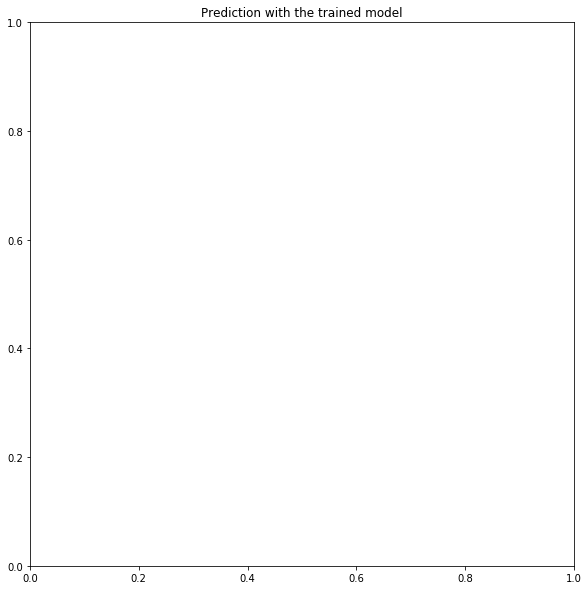

In [30]:
plt.figure(figsize=(13,10))
plt.title('Prediction with the trained model')
plt.imshow(prediction)

In [35]:
print(prediction)

[array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 2, 2, 1],
       [1, 1, 1, ..., 2, 2, 1],
       ...,
       [1, 2, 2, ..., 2, 2, 1],
       [1, 2, 2, ..., 2, 2, 1],
       [1, 1, 1, ..., 1, 1, 1]], dtype=uint8)]


In [8]:
a='weighted_cost'
key1, key2 = a.split('_')
print(key1,key2)

('weighted', 'cost')


In [21]:
from AxonDeepSeg.train_network_tools import *

data_augmentation = generate_dict_da(config)
print(data_augmentation)



{'random_rotation': {'activate': False}, 'elastic': {'activate': True}, 'flipping': {'activate': True}, 'shifting': {'activate': True}, 'noise_addition': {'activate': False}, 'rescaling': {'activate': False}, 'type': 'all'}


In [22]:
weights_modifier = generate_dict_weights(config)
print(weights_modifier)

{'boundaries_activate': False, 'balanced_weights': [1.1, 1, 1.3], 'activate': True, 'boundaries_sigma': 2, 'balanced_activate': True}


In [ ]:
config = {
  "learning_rate_decay_period": 24000, 
  "batch_norm_decay_decay_period": 16000, 
  "learning_rate_decay_type": "polynomial", 
  "batch_norm_decay_decay_activate": True, 
  "learning_rate_decay_activate": True, 
  "learning_rate_decay_rate": 0.99, 
  "batch_norm_decay_ending_decay": 0.9, 
  "depth": 3, 
  "weighted_cost_activate": False, 
  "weighted_cost_balanced_activate": False, 
  "weighted_cost_balanced_weights": [1, 1], 
  "weighted_cost_boundaries_sigma": 2, 
  "weighted_cost_boundaries_activate": False,
  "batch_norm_activate": True, 
  "thresholds": [0, 0.5], 
  "trainingset_patchsize": 512, 
  "learning_rate": 0.001, 
  "downsampling": "maxpooling", 
  "batch_size": 8, 
  "da-type": "all", 
  "n_classes": 2, 
  "batch_norm_decay_starting_decay": 0.7, 
  "trainingset": "data_training", 
  "size_of_convolutions_per_layer": [[3,3],[3,3],[3,3],[3,3]], 
  "dropout": 0.75, 
  "convolution_per_layer": [2, 2, 2], 
  "features_per_convolution": [[[10,15],[15,20]],[[20,25],[25,30]],[[30,35],[35,40]]]
}

In [13]:
config = {
  "learning_rate_decay_period": 24000, 
  "batch_norm_decay_decay_period": 16000, 
  "learning_rate_decay_type": "polynomial", 
  "batch_norm_decay_decay_activate": True, 
  "learning_rate_decay_activate": True, 
  "learning_rate_decay_rate": 0.99, 
  "batch_norm_decay_ending_decay": 0.9, 
  "depth": 4, 
  "weighted_cost_activate": True, 
  "weighted_cost_balanced_activate": True, 
  "weighted_cost_balanced_weights": [1.1, 1, 1.3], 
  "weighted_cost_boundaries_sigma": 2, 
  "weighted_cost_boundaries_activate": False,
  "batch_norm_activate": True, 
  "thresholds": [0, 0.2, 0.8], 
  "trainingset_patchsize": 512, 
  "learning_rate": 0.001, 
  "downsampling": "convolution", 
  "batch_size": 8, 
  "da-type": "all", 
  "da-random_rotation-activate": False, 
  "da-noise_addition-activate": False, 
  "da-elastic-activate": True, 
  "da-shifting-activate": True, 
  "da-flipping-activate": True, 
  "da-rescaling-activate": False,
  "n_classes": 3, 
  "batch_norm_decay_starting_decay": 0.7, 
  "trainingset": "SEM_3c_512", 
  "size_of_convolutions_per_layer": [[5, 5, 5], [3, 3, 3], [3, 3, 3], [3, 3, 3]], 
  "dropout": 0.75, 
  "convolution_per_layer": [3, 3, 3, 3], 
  "features_per_convolution": [[[1, 16], [16, 16], [16, 16]], 
                               [[16, 32], [32, 32], [32, 32]], 
                               [[32, 64], [64, 64], [64, 64]], 
                               [[64, 128], [128, 128], [128, 128]]]
}

In [7]:
print(config)

{'learning_rate_decay_period': 24000, 'trainingset_patchsize': 256, 'thresholds': [0, 0.2, 0.8], 'batch_norm_decay_decay_period': 16000, 'learning_rate_decay_type': 'polynomial', 'da-type': 'all', 'batch_size': 8, 'convolution_per_layer': [2, 2, 2, 2], 'da-random_rotation-activate': False, 'features_per_convolution': [[[1, 5], [5, 5]], [[5, 10], [10, 10]], [[10, 15], [15, 15]], [[15, 20], [20, 20]]], 'batch_norm_activate': True, 'learning_rate_decay_rate': 0.99, 'batch_norm_decay_ending_decay': 0.9, 'da-shifting-activate': True, 'weighted_cost-balanced_weights': [1.1, 1, 1.3], 'dataset_variance': 30, 'learning_rate': 0.001, 'da-elastic-activate': True, 'da-noise_addition-activate': False, 'weighted_cost-activate': True, 'dataset_mean': 128, 'downsampling': 'maxpooling', 'size_of_convolutions_per_layer': [[3, 3], [3, 3], [3, 3], [3, 3]], 'weighted_cost-boundaries_sigma': 2, 'weighted_cost-boundaries_activate': False, 'batch_norm_decay_decay_activate': True, 'depth': 4, 'da-flipping-acti

In [ ]:
config = {
  "learning_rate_decay_period": 24000, 
  "batch_norm_decay_decay_period": 16000, 
  "learning_rate_decay_type": "polynomial", 
  "batch_norm_decay_decay_activate": True, 
  "learning_rate_decay_activate": True, 
  "learning_rate_decay_rate": 0.99, 
  "batch_norm_decay_ending_decay": 0.9, 
  "depth": 3, 
  "weighted_cost_activate": False, 
  "weighted_cost_balanced_activate": False,  
  "weighted_cost_boundaries_activate": False,
  "batch_norm_activate": True, 
  "thresholds": [0, 0.5], 
  "trainingset_patchsize": 512, 
  "learning_rate": 0.001, 
  "downsampling": "maxpooling", 
  "batch_size": 8, 
  "da-type": "all", 
  "n_classes": 2, 
  "batch_norm_decay_starting_decay": 0.7, 
  "trainingset": "data_training", 
  "size_of_convolutions_per_layer": [[3,3],[3,3],[3,3],[3,3]], 
  "dropout": 0.75, 
  "convolution_per_layer": [2, 2, 2], 
  "features_per_convolution": [[[10,15],[15,20]],[[20,25],[25,30]],[[30,35],[35,40]]]
}

[44 44 44]
[44 44 44]


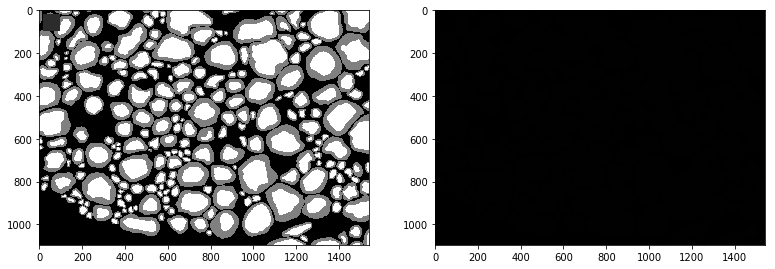

In [12]:
import imageio
import matplotlib.pyplot as plt
%matplotlib inline
from AxonDeepSeg.data_management.input_data import labellize_mask_2d



mask = imageio.imread('/Users/rudinakaprata/Documents/Aldo/ads_feb/axondeepseg/AxonDeepSeg/data_test/mask.png')




mask[20:100,20:100,:]=300
mask2, aaa = labellize_mask_2d(mask, [0,0.5])

plt.figure(figsize=(13,10))
plt.subplot(121)
plt.imshow(mask)
plt.subplot(122)
plt.imshow(aaa)

print(mask[20,20,:])
print(mask2[20,20,:])

In [5]:
print(aaa)

[[[1 1 1]
  [1 1 1]
  [1 1 1]
  ...
  [1 1 1]
  [1 1 1]
  [1 1 1]]

 [[1 1 1]
  [1 1 1]
  [1 1 1]
  ...
  [1 1 1]
  [1 1 1]
  [1 1 1]]

 [[1 1 1]
  [1 1 1]
  [1 1 1]
  ...
  [1 1 1]
  [1 1 1]
  [1 1 1]]

 ...

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [1 1 1]
  [1 1 1]
  [1 1 1]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [1 1 1]
  [1 1 1]
  [1 1 1]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [1 1 1]
  [1 1 1]
  [1 1 1]]]
